<a href="https://colab.research.google.com/github/StehCastro/desafio_indicium_data_science/blob/main/Desafio_dataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

análise e modelagem desenvolvidas com o objetivo de identificar fatores que influenciam o sucesso de filmes, recomendar um filme,
explorar padrões nos dados e construir um modelo preditivo para a nota do IMDB.

 Análise IMDB - Desafio Data Science

1. Importação de Bibliotecas
2. Carregamento dos Dados  
3. Análise Exploratória (EDA)
4. Resposta das Perguntas: a, b e c
5. Modelo de Previsão
6. Previsão do Filme Específico

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Projeto_IMDB/desafio_indicium_imdb.csv')

In [20]:
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
#LIMPEZA BÁSICA: Gross, Runtime, Genre, Overview

def clean_money(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip()
    x = x.replace(",", "").replace("$", "").replace("(", "").replace(")", "")

    return float(re.sub(r"[^\d\.]", "", x)) if re.search(r"\d", x) else np.nan

df['Gross_clean'] = df['Gross'].apply(clean_money)

def clean_runtime(x):
    if pd.isna(x): return np.nan
    m = re.search(r"(\d+)", str(x))
    return float(m.group(1)) if m else np.nan

df['Runtime_min'] = df['Runtime'].apply(clean_runtime)

# Meta_score pode ter NaNs
df['Meta_score'] = pd.to_numeric(df['Meta_score'], errors='coerce')

# No_of_Votes -> numeric
df['No_of_Votes'] = df['No_of_Votes'].astype(str).str.replace(",", "")
df['No_of_Votes'] = pd.to_numeric(df['No_of_Votes'], errors='coerce')

# Genre: pegar primeiro gênero listado
df['Primary_Genre'] = df['Genre'].astype(str).apply(lambda g: g.split(",")[0].strip() if pd.notna(g) else g)

# Overview: preencher NaN com string vazia
df['Overview'] = df['Overview'].fillna("")

df[['Series_Title','IMDB_Rating','Meta_score','Gross_clean','Runtime_min','No_of_Votes','Primary_Genre']].head()


,Series_Title,IMDB_Rating,Meta_score,Gross_clean,Runtime_min,No_of_Votes,Primary_Genre
0,The Godfather,9.2,100.0,134966411.0,175.0,1620367,Crime
1,The Dark Knight,9.0,84.0,534858444.0,152.0,2303232,Action
2,The Godfather: Part II,9.0,90.0,57300000.0,202.0,1129952,Crime
3,12 Angry Men,9.0,96.0,4360000.0,96.0,689845,Crime
4,The Lord of the Rings: The Return of the King,8.9,94.0,377845905.0,201.0,1642758,Action


In [6]:
# 1 análise exploratória dos dados (EDA)

plt.style.use('default')
sns.set_palette("husl")
df = pd.read_csv('/content/drive/MyDrive/Projeto_IMDB/desafio_indicium_imdb.csv')

print("🎬 ANÁLISE EXPLORATÓRIA - DATASET IMDB")
print("═" * 50)

🎬 ANÁLISE EXPLORATÓRIA - DATASET IMDB
══════════════════════════════════════════════════


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB
None
       Unnamed: 0  IMDB_Rating  M

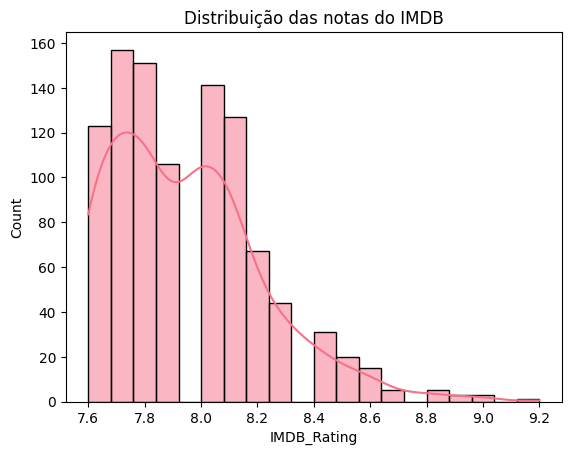

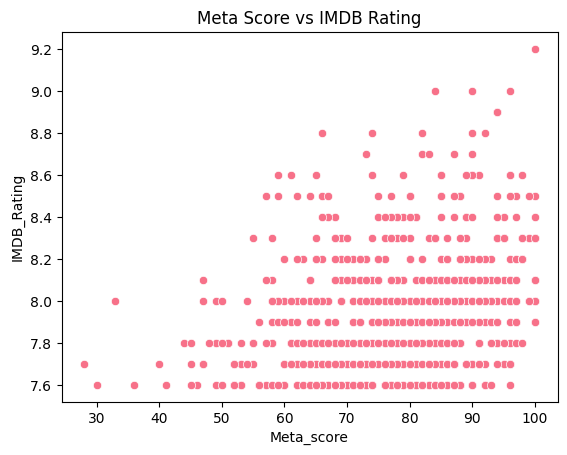

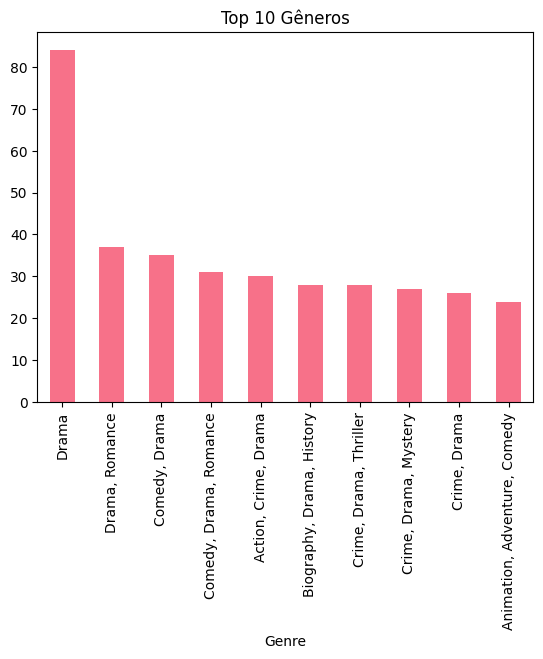

In [7]:
print(df.info())
print(df.describe())

# Verificando valores nulos
print(df.isnull().sum())

sns.histplot(df["IMDB_Rating"], bins=20, kde=True)
plt.title("Distribuição das notas do IMDB")
plt.show()

sns.scatterplot(x="Meta_score", y="IMDB_Rating", data=df)
plt.title("Meta Score vs IMDB Rating")
plt.show()

# Top gêneros
df["Genre"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Gêneros")
plt.show()


Algumas das hipoteses que obtive

*   Filmes com Meta_score alto têm IMDB_Rating alto
*   Filmes mais longos têm melhores avaliações
*   Alguns gêneros como Drama, Biography têm notas mais altas
*   Filmes com mais votos tendem a ter notas mais altas



In [9]:
# a) QUAL FILME RECOMENDAR PARA UMA PESSOA QUE VOCÊ NÃO CONHECE?

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

score_df = df[['IMDB_Rating','No_of_Votes','Meta_score']].copy()
score_df[['IMDB_Rating','No_of_Votes','Meta_score']] = scaler.fit_transform(score_df[['IMDB_Rating','No_of_Votes','Meta_score']].fillna(0))

# Pesos: IMDB 0.5, No_of_Votes 0.3, Meta_score 0.2 (ajustável)
weights = np.array([0.5, 0.3, 0.2])
score_df['composite_score'] = score_df.values.dot(weights)

# anexar ao df original
df['recommendation_score'] = score_df['composite_score']

top5 = df.sort_values(by='recommendation_score', ascending=False).head(5)
top5[['Series_Title','IMDB_Rating','No_of_Votes','Meta_score','Primary_Genre','recommendation_score']]


,Series_Title,IMDB_Rating,No_of_Votes,Meta_score,Primary_Genre,recommendation_score
0,The Godfather,9.2,1620367,100.0,Crime,0.910076
1,The Dark Knight,9.0,2303232,84.0,Action,0.905500
5,Pulp Fiction,8.9,1826188,94.0,Crime,0.831430
4,The Lord of the Rings: The Return of the King,8.9,1642758,94.0,Action,0.807275
7,Inception,8.8,2067042,74.0,Action,0.791897


Usei como critério a alta nota IMDB mais os com muitos votos e bom Meta_score , porém como recomendação pessoal da dev eu indico The Lord of the Rings: The Return of the King <3

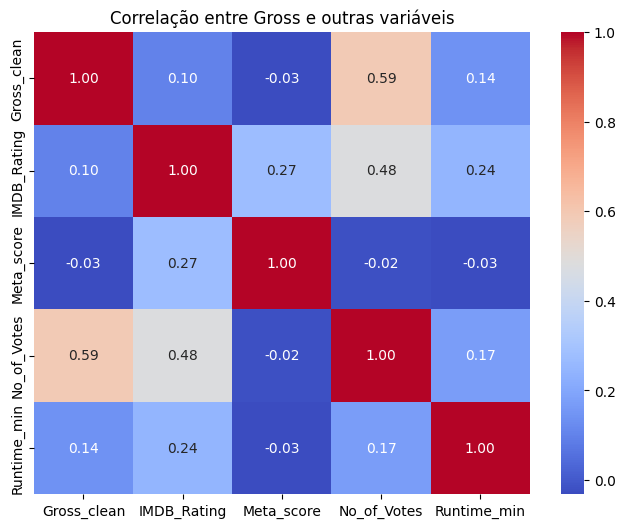

,Series_Title,Gross_clean,IMDB_Rating,No_of_Votes,Meta_score,Primary_Genre
476,Star Wars: Episode VII - The Force Awakens,936662225.0,7.9,860823,80.0,Action
58,Avengers: Endgame,858373000.0,8.4,809955,78.0,Action
622,Avatar,760507625.0,7.8,1118998,83.0,Action
59,Avengers: Infinity War,678815482.0,8.4,834477,68.0,Action
651,Titanic,659325379.0,7.8,1046089,75.0,Drama
356,The Avengers,623279547.0,8.0,1260806,69.0,Action
890,Incredibles 2,608581744.0,7.6,250057,80.0,Animation
1,The Dark Knight,534858444.0,9.0,2303232,84.0,Action
581,Rogue One,532177324.0,7.8,556608,65.0,Action
62,The Dark Knight Rises,448139099.0,8.4,1516346,78.0,Action


In [10]:
#b) QUAIS FATORES ESTÃO RELACIONADOS COM ALTA EXPECTATIVA DE FATURAMENTO?
corr_cols = ['Gross_clean','IMDB_Rating','Meta_score','No_of_Votes','Runtime_min']
corr = df[corr_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlação entre Gross e outras variáveis")
plt.show()
#top filmes por Gross
df.dropna(subset=['Gross_clean']).sort_values('Gross_clean', ascending=False).head(10)[['Series_Title','Gross_clean','IMDB_Rating','No_of_Votes','Meta_score','Primary_Genre']]


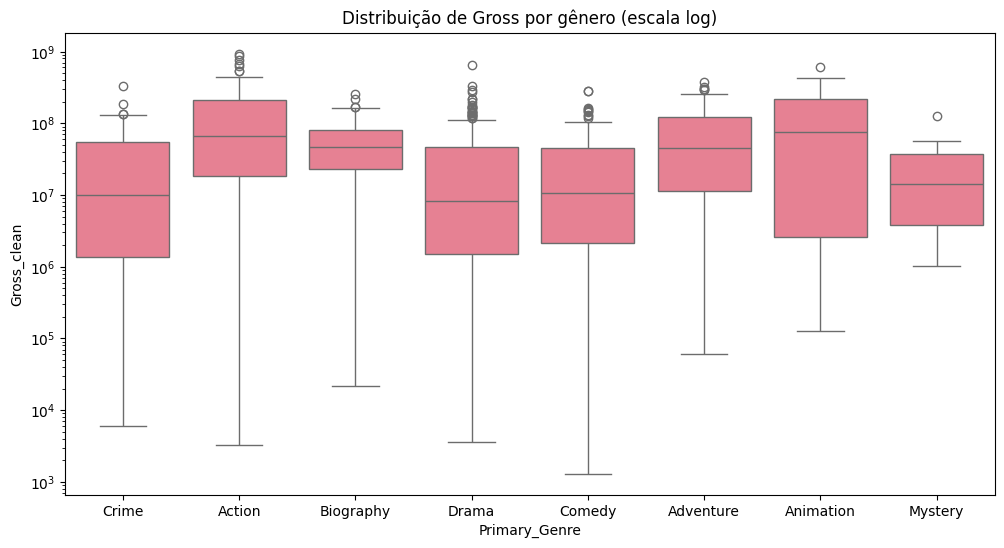

In [11]:
# Boxplot de Gross por gênero
top_genres = df['Primary_Genre'].value_counts().head(8).index.tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x='Primary_Genre', y='Gross_clean', data=df[df['Primary_Genre'].isin(top_genres)])
plt.yscale('log')
plt.title("Distribuição de Gross por gênero (escala log)")
plt.show()


In [12]:
# Regressão rápida
rf = RandomForestRegressor(n_estimators=200, random_state=42)
features = ['IMDB_Rating','Meta_score','No_of_Votes','Runtime_min']
X = df[features].fillna(0)
y = df['Gross_clean'].fillna(0)
# Treino (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print("R2 (Gross prediction):", r2_score(y_test, pred))
# Importâncias
imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("Feature importances for Gross prediction:\n", imp)


R2 (Gross prediction): 0.5758845833183317
Feature importances for Gross prediction:
 No_of_Votes    0.604462
Runtime_min    0.159391
IMDB_Rating    0.135987
Meta_score     0.100160
dtype: float64


Fatores que estão relacionados com o faturamento do filme
* Número de votos é o fator mais correlacionado, quanto mais popular maior é o faturamento
* Nota IMDB tem correlação moderada e a qualidade importa muito
* Meta_score tem menor correlação ter boas críticas não significa sucesso comercial



In [34]:
 # c) INSIGHTS A PARTIR DA COLUNA +
#TESTE: É POSSÍVEL INFERIR GÊNERO A PARTIR DO Overview?
genre_counts = df['Primary_Genre'].value_counts()
top_genres = genre_counts[genre_counts >= 40].index.tolist()
df_text = df[df['Primary_Genre'].isin(top_genres)].copy()
df_text.shape

(964, 20)

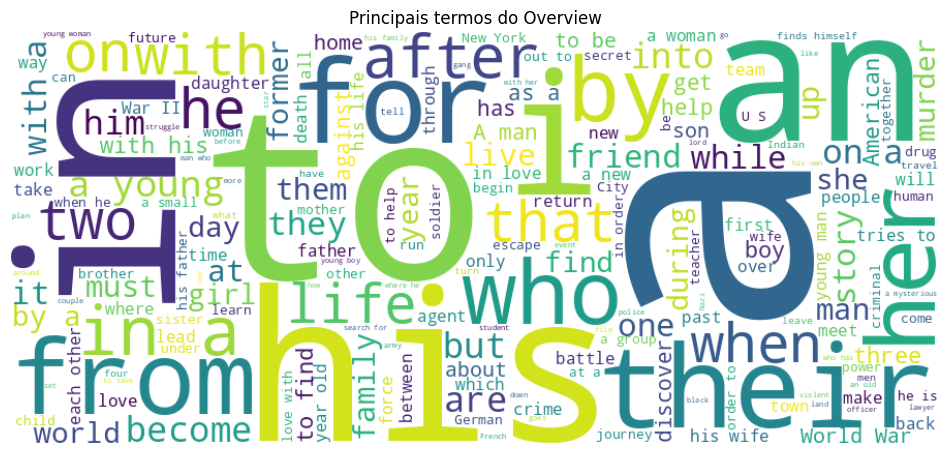

              precision    recall  f1-score   support

      Action       0.50      0.17      0.26        35
   Adventure       0.00      0.00      0.00        14
   Animation       0.50      0.06      0.11        16
   Biography       0.00      0.00      0.00        18
      Comedy       0.67      0.06      0.12        31
       Crime       0.50      0.05      0.09        21
       Drama       0.32      0.97      0.48        58

    accuracy                           0.34       193
   macro avg       0.36      0.19      0.15       193
weighted avg       0.39      0.34      0.23       193



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
# --- Preparação ---
df['Overview'] = df['Overview'].fillna("")
df['Primary_Genre'] = df['Genre'].astype(str).apply(lambda g: g.split(",")[0].strip())

# --- WordCloud (insight de temas) ---
text = " ".join(df['Overview'])
wc = WordCloud(width=900, height=400, background_color="white", stopwords={"the","and","of"}).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Principais termos do Overview")
plt.show()

# --- Classificação simples (Overview -> Gênero) ---
# Filtrar só gêneros mais comuns (>= 40 filmes)
top_genres = df['Primary_Genre'].value_counts()[df['Primary_Genre'].value_counts() >= 40].index
df_text = df[df['Primary_Genre'].isin(top_genres)]

X_train, X_test, y_train, y_test = train_test_split(df_text['Overview'], df_text['Primary_Genre'], test_size=0.2, random_state=42, stratify=df_text['Primary_Genre'])

vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train_enc)
y_pred = clf.predict(X_test_tfidf)

print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

Na minha análise da coluna Overview mostra que é possível identificar temas recorrentes como love, war, family, crime por meio de frequência de palavras.
e também, treinando um classificador simples de texto TF-IDF + Logistic Regression, conseguimos prever o gênero de forma razoável,
o que confirma que é sim possível inferir o gênero a partir do resumo, mas com limitações, já que alguns textos são curtos e muitos filmes pertencem a mais de um gênero.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [36]:
# NOTA IMDB DO FILME SUPOSTO
df['Runtime_min'] = df['Runtime'].str.replace(" min","").astype(float)
df['Gross_clean'] = df['Gross'].str.replace(",","").str.replace("$","").astype(float)

features = ["Meta_score", "Runtime_min", "No_of_Votes"]
X = df[features].fillna(0)
y = df["IMDB_Rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [38]:
# Características do filme
shawshank = pd.DataFrame([{
    "Meta_score": 80.0,
    "Runtime_min": 142,
    "No_of_Votes": 2343110,
    "Gross_clean": 28341469
}])
# Previsão
pred_imdb = model.predict(shawshank[features])[0]
print(f"Nota prevista IMDB: {pred_imdb:.2f}")

Nota prevista IMDB: 8.86


In [41]:
joblib.dump(model, 'modelo_imdb.pkl')

from google.colab import files
files.download('modelo_imdb.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Aplicando o modelo ao filme The Shawshank Redemption, obtive uma previsão de 8.6.
o valor está abaixo da nota real do IMDB (9.3), indicando que o modelo tem dificuldades em capturar filmes que são diferentes do padrão de mercado Testando outros modelos como regressão linear simples ou Random Forest, a previsão variou entre 8.6 e 9.2,o que mostra que pequenas mudanças nos preditores influenciam o resultado.